# Импорты


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from itertools import combinations
import seaborn as sns
import numpy as np
pd.set_option('display.max_columns', None)
%matplotlib inline

**Переменные**

1) pollution_static - целевая переменная, уровень загрязняющих веществ 

2) population - население региона 

3) income - средний уровень доходов населения 

4) GRP_pc - ВРП региона 

5) manufactory - уровень промышленности (как оборот) 

6) spending - государственные затраты на охрану окр.среды 

7) urban - уровень урбанизации региона 

Все показатели взяты с Росстата. 




In [3]:
df = pd.read_excel(r'C:\Users\Anastasia\Downloads\superdata.xlsx')
df = df[df['year'] == 2016].set_index(['region', 'okrug'])
df = df[['pollution_static', 'population', 'income', 'GRP_pc', 'manufactory', 'spending', 'urban']]
df = pd.DataFrame(scale(df), columns=df.columns, index=df.index)
print(df.shape)
df.head()

(82, 7)


,,pollution_static,population,income,GRP_pc,manufactory,spending,urban
region,okrug,,,,,,,
Алтайский край,Сибирский федеральный округ,0.003384,0.320632,-0.633836,-0.659159,-0.238831,-0.437131,-1.024200
Иркутская область,Сибирский федеральный округ,1.085669,0.344580,-0.548256,0.162499,0.044986,0.900443,0.673972
Кемеровская область,Сибирский федеральный округ,2.869295,0.511660,-0.659810,-0.285579,0.073427,0.324370,1.192441
Красноярский край,Сибирский федеральный округ,5.427424,0.604111,0.091876,0.770967,0.765666,3.580341,0.546234
Новосибирская область,Сибирский федеральный округ,-0.026889,0.551203,-0.199830,-0.020421,-0.039124,-0.282588,0.673972


# Предварительный анализ данных

Анализ распределения до и после удаления выбросов

In [8]:
# 3 сигмы 
from scipy import stats
dfnew = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

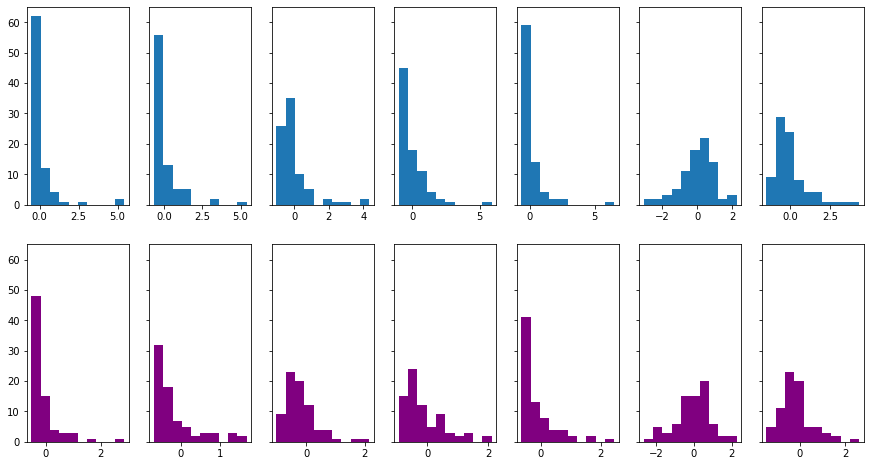

In [11]:
fig, axes = plt.subplots(nrows=2,ncols=7, figsize=(15,8), sharey=True)

for i, method in enumerate(['pollution_static', 'spending', 'GRP_pc', 'population','manufactory','urban','income']):
    axes[0, i].hist(df[method])
    axes[1, i].hist(dfnew[method],color='purple')


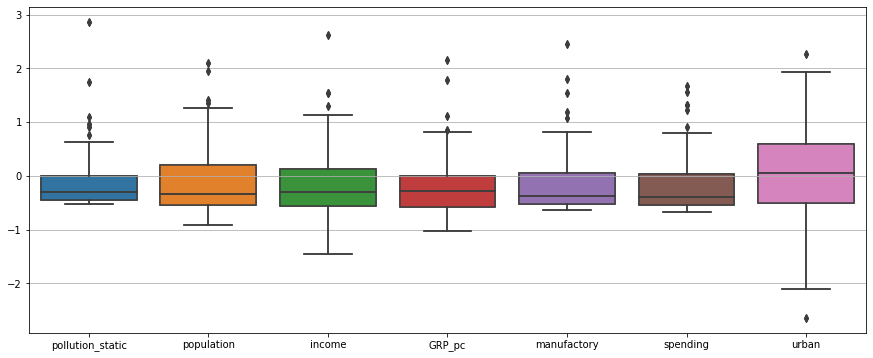

In [19]:
fig = plt.figure(figsize=(15,6))
sns.boxplot(data=dfnew)
plt.grid()
sns.boxplot(data=dfnew)


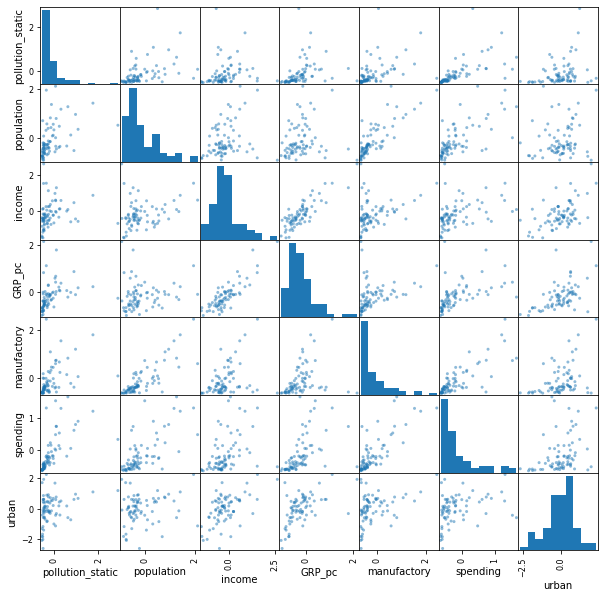

In [22]:
from pandas.plotting import scatter_matrix
newscatter = scatter_matrix(dfnew, figsize=(10, 10), )

## Кластеризация наблюдений

Для определения оптимального числа кластеров: 

1) Проведем последовательную иерархическую кластеризацию и определим условную  " наполненность кластеров" при том или ином их количестве

2) Проведем предварительную диагностику числа кластеров с помощью формальных тестов

## Иерархическая кластеризация 

In [23]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
linked = linkage(dfnew, method='ward')


Text(0.5, 1.0, 'Ward')

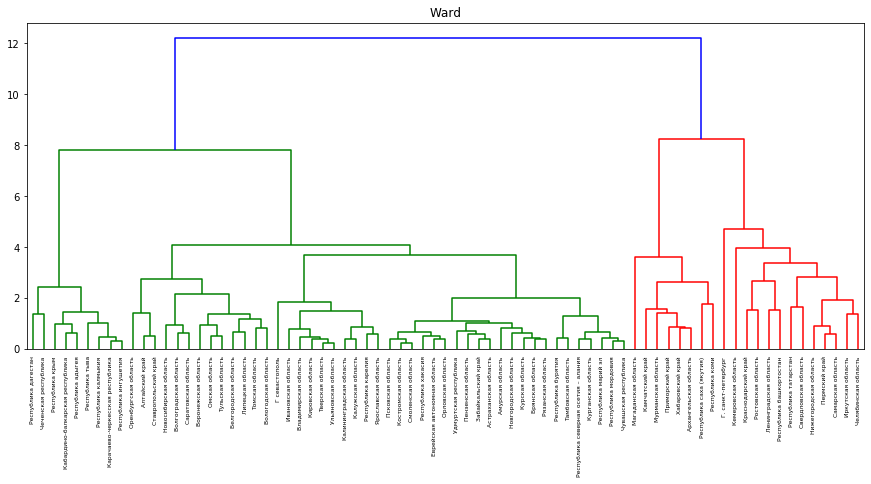

In [24]:
fig = plt.figure(figsize=(15,6))
dendrogram(linked,
            orientation='top',
            labels=dfnew.index.get_level_values(0),
            distance_sort='descending',
            show_leaf_counts=True);
plt.title('Ward')

## Оптимальность заполнения

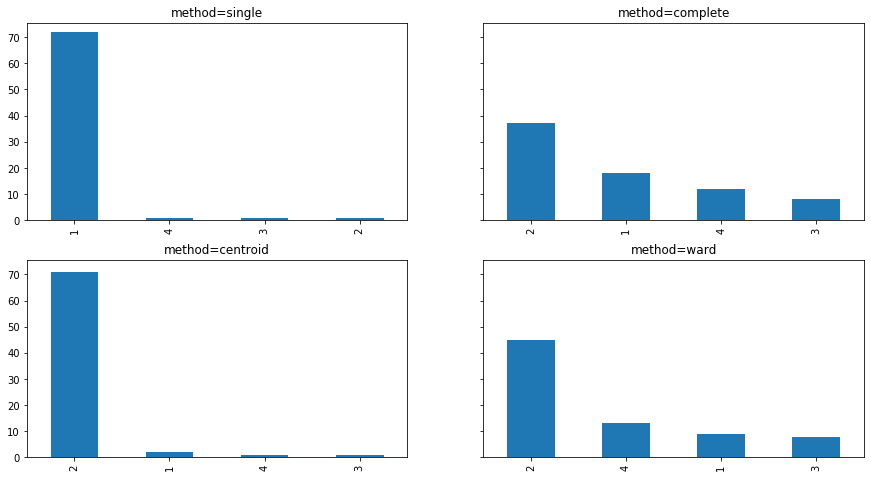

In [25]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(15,8), sharey=True)

for i, method in enumerate(['single', 'complete', 'centroid', 'ward']):
    pd.Series(fcluster(linkage(dfnew, method=method), criterion='maxclust', t=4)).value_counts().plot.bar(ax=axes[i//2][i%2])
    axes[i//2][i%2].set_title('method='+method)



Наиболее оптимальное заполнение происходит с помощью метода дальнего соседа и метода Варда - при 4 кластерах

Можем проверить это предположение с помощью метрики силуэтов и метода локтя 

## Силуэт для агломеративных процедур кластеризации

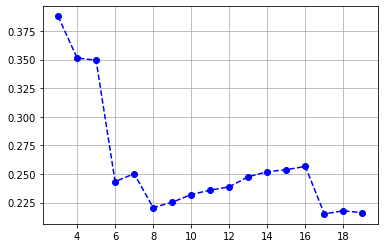

In [28]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
n_clusters = np.arange(3, 20)
scores = []

for n_cluster in n_clusters:
    km = AgglomerativeClustering(n_clusters=n_cluster)
    cl = km.fit_predict(dfnew)
    scores.append(silhouette_score(dfnew, cl))
    
plt.plot(n_clusters, scores, 'b--o')
plt.grid()

При разбиение на 3 кластера - максимальный silhouette score

In [29]:
scores

[0.3878479582118887,
 0.3514105857380695,
 0.34941127195813293,
 0.24340307575643114,
 0.2502720516306287,
 0.22073436171464816,
 0.22527195655736132,
 0.23210751677982158,
 0.23595813853716302,
 0.23881566623542214,
 0.24763761188002045,
 0.25194158813668505,
 0.2538262016511135,
 0.25662763917564485,
 0.21515297418362317,
 0.21786247509789963,
 0.2161922466872342]

## Кластерный анализ ( k-means)

Предопределим число кластеров с помощью формальных тестов

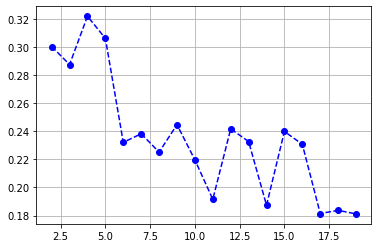

In [31]:
n_clusters = np.arange(2, 20)
scores = []
for n_cluster in n_clusters:
    km = KMeans(n_clusters=n_cluster)
    clusters = km.fit_predict(dfnew)
    scores.append(silhouette_score(dfnew, clusters))

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(n_clusters, scores, 'b--o')
plt.grid()
plt.savefig(r'C:\Users\Anastasia\Documents\майнор\отчет1\Текст. Кластерный анализ\картинки\силуэтkmeans.png')

In [32]:
scores


[0.300462959132802,
 0.28763693724359113,
 0.32207109158851266,
 0.3062735749490364,
 0.2321568845418085,
 0.23829719899773147,
 0.22519552608966345,
 0.2447761439665938,
 0.2196760301393672,
 0.19153976474760262,
 0.2417648538788651,
 0.23277384766064543,
 0.18736202390324352,
 0.23993245524597043,
 0.23076860833376292,
 0.18143333277764298,
 0.18370198535976182,
 0.18115118511674647]

Наибольший Silhouette score при числе кластеров - 4 при кластеризации методом k-means

**Провери это же с помощью метода локтя**


Text(0, 0.5, 'WCSS')

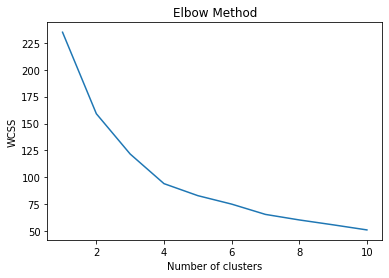

In [34]:
#метод локтя
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(dfnew)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')


Метод локтя также показал оптимальное количество кластеров  4

**Проведем непосредственно кластеризацию**


In [35]:
km = KMeans(n_clusters = 4, random_state= 1)
clusters = km.fit_predict(dfnew)
centers = pd.DataFrame(km.cluster_centers_,columns = dfnew.columns) 


In [36]:
clusters

array([0, 1, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 2, 1, 2, 1,
       3, 2, 2, 2, 3, 2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 0, 1,
       1, 2, 2, 2, 0, 0, 1, 1, 0])

In [37]:
cents = centers.copy().T

In [39]:
cents.index =  ['Загрязнение', 'Население','Доход',"ВРП","Промышленность",'Гос. затраты', 'Урбанизация']

**Центры кластеров**

In [43]:
cents

,0,1,2,3
Загрязнение,-0.429193,0.579361,-0.253753,-0.001661
Население,-0.318247,1.010460,-0.314302,-0.557098
Доход,-0.813677,0.198862,-0.285834,1.235548
ВРП,-0.743944,0.083117,-0.298052,1.018292
Промышленность,-0.522119,0.932251,-0.262067,-0.472133
Гос. затраты,-0.539835,0.846327,-0.365547,0.025878
Урбанизация,-1.377860,0.480341,0.154752,0.858603


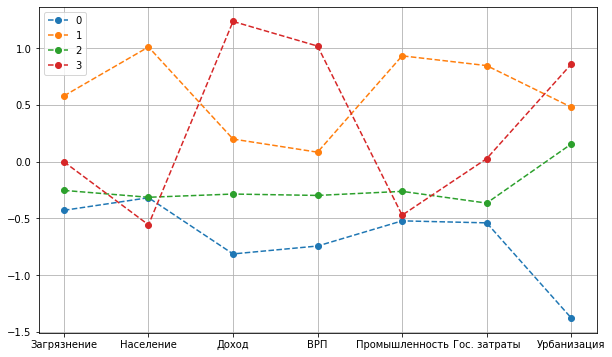

In [42]:
fig = plt.figure(figsize=(10,6))
plt.plot(cents, linestyle='--', marker='o')
plt.legend(cents.columns)
plt.grid()

Визуализируем изначальные данные с помощью снижения размерности

(-300, 250)

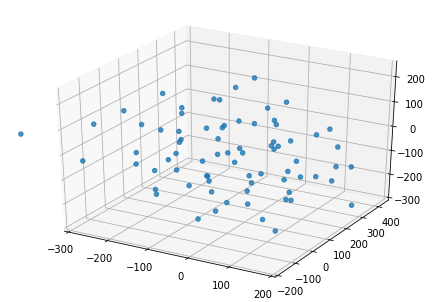

In [44]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
fig = pyplot.figure()
ax = Axes3D(fig)
X = dfnew.values
tsne_x = TSNE(n_components=3).fit_transform(X)
tsne_x = np.array(tsne_x)
ax.scatter(tsne_x[:,0], tsne_x[:,1],tsne_x[:,2], alpha = 0.8)
ax.set_xlim(-300, 200)
ax.set_ylim(-200, 450)
ax.set_zlim(-300, 250)

А теперь окрасим точки в зависимости от принадлежности к тому или иному кластеру

(-300, 250)

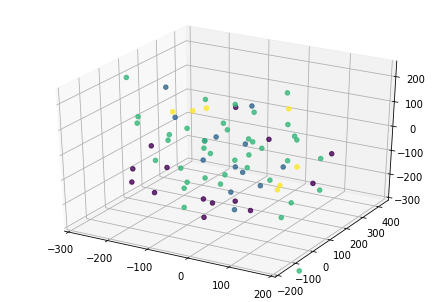

In [45]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
fig = pyplot.figure()
ax = Axes3D(fig)
X = dfnew.values
tsne_x = TSNE(n_components=3).fit_transform(X)
tsne_x = np.array(tsne_x)
ax.scatter(tsne_x[:,0], tsne_x[:,1],tsne_x[:,2], c=clusters, alpha = 0.8)
ax.set_xlim(-300, 200)
ax.set_ylim(-200, 450)
ax.set_zlim(-300, 250)


In [46]:
dfnew.reset_index()['okrug'].unique()
colors = {'Сибирский федеральный округ': 'red', 
           'Дальневосточный федеральный округ': 'blue',
       'Северо-Западный федеральный округ':'yellow',
           'Южный федеральный округ':'green',
       'Центральный федеральный округ': 'black', 
           'Отдельный субъект':'brown',
       'Приволжский федеральный округ':'pink', 
           'Уральский федеральный округ':'purple',
       'Крымский федеральный округ':'indigo'}

col = [colors[okrug] for okrug in dfnew.index.get_level_values(1)]

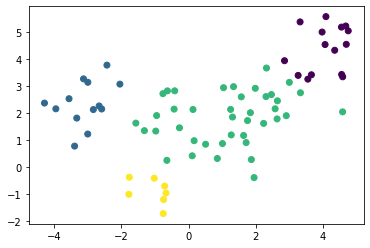

In [72]:
X = dfnew.values
tsne_x = TSNE(n_components=2, random_state=7).fit_transform(X)
tsne_x = np.array(tsne_x)
plt.scatter(tsne_x[:,0],tsne_x[:,1],c = clusters)

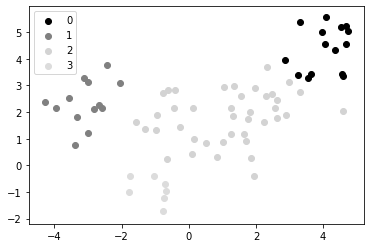

In [71]:
import seaborn as sns


scatter_list = []
unique_clusters = np.unique(clusters)
for n_cl, color in zip(unique_clusters, ['black', 'grey', 'lightgrey', 'gainsboro']):
    curr_x = tsne_x[clusters == n_cl]
    curr_scatter = plt.scatter(curr_x[:, 0], curr_x[:, 1], color=color, label=n_cl)
    scatter_list.append(curr_scatter)
plt.legend()

In [79]:
curr_scatter

## Таблица классификации

In [74]:
dfnew['clusters'] = clusters

C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
cl_df = dfnew.reset_index().groupby('clusters')['region'].unique().to_frame('Regions')
cl_df['cluster_size'] = cl_df['Regions'].map(len)
with pd.option_context('display.max_colwidth', 99999):
    display(cl_df)
# plt.savefig(r'C:\Users\Anastasia\Documents\майнор\отчет1\Текст. Кластерный анализ\картинки\classes.png')

,Regions,cluster_size
clusters,,
0,"[Алтайский край, Республика бурятия, Республика тыва, Кабардино-балкарская республика, Карачаево-черкесская республика, Республика адыгея, Республика дагестан, Республика ингушетия, Республика калмыкия, Ставропольский край, Чеченская республика, Республика мордовия, Чувашская республика, Курганская область, Республика крым]",15
1,"[Иркутская область, Кемеровская область, Г. санкт-петербург, Ленинградская область, Краснодарский край, Ростовская область, Нижегородская область, Пермский край, Республика башкортостан, Республика татарстан, Самарская область, Свердловская область, Челябинская область]",13
2,"[Новосибирская область, Омская область, Республика хакасия, Томская область, Амурская область, Еврейская автономная область, Забайкальский край, Приморский край, Вологодская область, Калининградская область, Новгородская область, Псковская область, Республика карелия, Астраханская область, Волгоградская область, Республика северная осетия – алания, Белгородская область, Брянская область, Владимирская область, Воронежская область, Ивановская область, Калужская область, Костромская область, Курская область, Липецкая область, Орловская область, Рязанская область, Смоленская область, Тамбовская область, Тверская область, Тульская область, Ярославская область, Г севастополь, Кировская область, Оренбургская область, Пензенская область, Республика марий эл, Саратовская область, Удмуртская республика, Ульяновская область]",40
3,"[Камчатский край, Магаданская область, Республика саха (якутия), Хабаровский край, Архангельская область, Мурманская область, Республика коми]",7


# Расстояние между центрами кластеров

In [77]:
from sklearn.metrics.pairwise import euclidean_distances
euclidean_distances(centers)

array([[0.        , 3.46142383, 1.71905099, 3.58732855],
       [3.46142383, 0.        , 2.41460889, 2.74455918],
       [1.71905099, 2.41460889, 0.        , 2.2051329 ],
       [3.58732855, 2.74455918, 2.2051329 , 0.        ]])

In [78]:
from sklearn.metrics import pairwise_distances
dist = pd.DataFrame(np.round(pairwise_distances(centers), 3))
dist

,0,1,2,3
0,0.000,3.461,1.719,3.587
1,3.461,0.000,2.415,2.745
2,1.719,2.415,0.000,2.205
3,3.587,2.745,2.205,0.000
